# Web Scraping for Reddit & Predicting Comments

This notebook is designed to see whether Reddit can be scraped and analyzed to find patterns in comments.
It is intended to be as a guide to writing a post that gets an above average number of comments.

In [13]:
# imports

import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np

% matplotlib inline

### Scraping Thread Info from Reddit.com

In [ ]:
'''

Import PRAW, a Reddit API wrapper for Python, and pass the secrets to it for authentication purposes.

'''

import praw

reddit = praw.Reddit(client_id='#####',
                     client_secret='#####',
                     user_agent='my user agent')

In [ ]:
'''

Make sure you have access, and it's read-only.

'''

print 'Read-only access:', (reddit.read_only)

In [ ]:
'''

Make requests to the API and parse them.

'''

# instantiate the lists
ids = []
titles = []
subreddits = []
num_comments = []
t3_ids = []
upvotes = []
created_at = []
time_now = []
time_delta = []

'''

PRAW lets you grab data is JSONs - this makes parsing easy-peasy.

'''

# iterate through the top n reddits
for submission in reddit.subreddit('all').hot(limit = 10000):
    
    # update the lists as we go
    ids.append(submission.id) # id
    titles.append(submission.title) # title appearing on the front page
    subreddits.append(submission.subreddit) # subreddit that the reddit was posted in
    num_comments.append(submission.num_comments) # number of comments to the reddit
    t3_ids.append(submission.name) 
    upvotes.append(submission.ups) # number of upvotes
    created_at.append(submission.created_utc) # time the reddit was created in linux time
    time_now.append(datetime.datetime.utcnow()) # time that reddit was scraped
    time_delta.append(datetime.datetime.utcnow() - datetime.datetime.utcfromtimestamp(submission.created_utc)) # time elapsed
    
    
    
# confirm that all the lists are of the same length. Otherwise, we can't create a dataframe out of them.
print len(ids), len(titles), len(subreddits), len(num_comments), len(t3_ids), len(upvotes), len(created_at), len(time_now), len(time_delta)

### Export to .csv and clean it up

In [ ]:
# Format as a DataFrame

df = pd.DataFrame({'id': ids, 'title': titles, 'subreddit': subreddits, 'num_comments': num_comments, 
                   'upvotes': upvotes, 'created_at': created_at, 'time_now': time_now, 'time_delta': time_delta})

In [ ]:
'''

1. Reddit keeps their ids as numbers in base 36. 
2. Times are in UTC.
3. Subreddit topics remain the PRAW object instead of a string.
4. Add a column to differentiate between 

'''

# 1 make a base 36 converter and convert

def base36decode(number): 
    return int(number, 36)

df.id = df.id.apply(lambda x: base36decode(x)) 

# 2 convert times 

df.created_at = df.created_at.apply(lambda x: datetime.datetime.utcfromtimestamp(x)) 

# 3 extract display name

df.subreddit = df.subreddit.apply(lambda x: x.display_name) 

# 4 engineer the target column

df['high'] = df.num_comments.apply(lambda x: 1 if x > df.num_comments.median() else 0) 

In [ ]:
# Export as a .csv.

df.to_csv('scraping_results_5.csv', encoding = 'utf-8', index = False)

In [ ]:
'''

This was scraped over four days and contains some duplicates. 
Remove duplicates.

'''

# read the final csv
df = pd.read_csv('./scraping_11k.csv')

# make sure the 'high' column is correct
df['high'] = df.num_comments.apply(lambda x: 1 if x > df.num_comments.median() else 0)

# check for duplicates
print 'shape w/duplicates:', df.shape
df = df.drop_duplicates(subset='id')
print 'shape w/o duplicates:', df.shape

# save to a final df to not re-do this every time.
df.to_csv('final.csv', index = False)

# EDA

In [4]:
'''

Convert time delta to a datetime.

'''

df = pd.read_csv('./final_final.csv')

In [5]:
'''

Grab the time elapsed in hours.

'''

df['days_elapsed'] = df.time_delta.apply(lambda x: float(x.split()[0]))
df['hours_elapsed'] = df.time_delta.apply(lambda x: float(x.split()[2].split(":")[0]))
df['minutes_elapsed'] = df.time_delta.apply(lambda x: float(x.split()[2].split(":")[1]))
df['seconds_elapsed'] = df.time_delta.apply(lambda x: float(x.split()[2].split(":")[2]))
df['composite_elapsed_hrs'] = df.days_elapsed * 24 + df.hours_elapsed + \
                                df.minutes_elapsed / 60 + df.seconds_elapsed / 3600

'''

Make sure the 'high' column is correct.

'''

df['high'] = df.num_comments.apply(lambda x: 1 if x > df.num_comments.median() else 0)


'''

Save back into final.csv

'''
df.to_csv('final_final.csv', index = False)

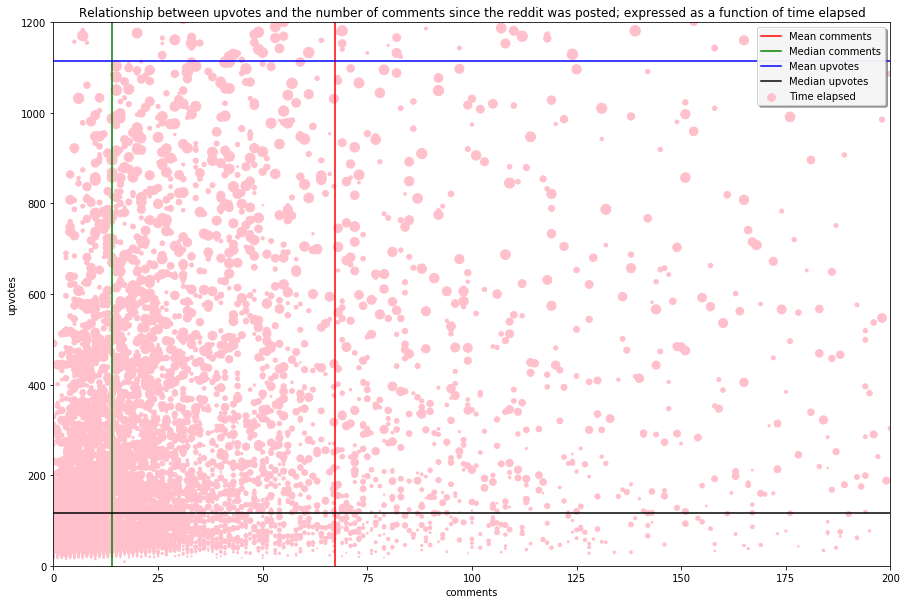

In [6]:
# I thought I would see some correlation.

plt.figure(figsize = (15, 10))
graph = plt.scatter(df['num_comments'], df['upvotes'], c = 'pink', s = df['composite_elapsed_hrs'] ** 1.5)
plt.xlabel('comments')
plt.ylabel('upvotes')
plt.xlim(0, 200)
plt.ylim(0, 1200)

mean_comments = plt.axvline(x=df.num_comments.mean(), color='r', linestyle='-')
median_comments = plt.axvline(x=df.num_comments.median(), color='g', linestyle='-')
mean_upvotes = plt.axhline(y=df.upvotes.mean(), color='b', linestyle='-')
median_upvotes = plt.axhline(y=df.upvotes.median(), color='black', linestyle='-')

plt.legend([mean_comments, median_comments, mean_upvotes, median_upvotes, graph], 
           ['Mean comments', 'Median comments', 'Mean upvotes', 'Median upvotes', 'Time elapsed'],
          framealpha=0.9, shadow=True, fancybox=True)

plt.title('Relationship between upvotes and the number of comments since the reddit was posted; expressed as a function of time elapsed')

plt.savefig('comments_vs_upvotes.png')

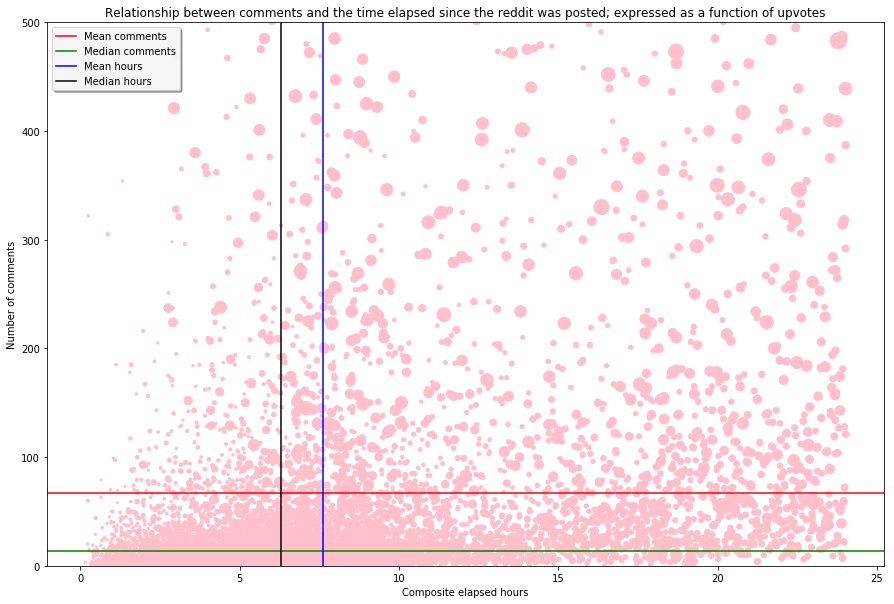

In [7]:
'''

You can see, albeit vaguely, that lower comments/lower elapsed time is more dense than less comments/more elapsed time.
This is roughly what you would expect, but the relationship is negligible.

'''

plt.figure(figsize = (15, 10))
plt.scatter(df['composite_elapsed_hrs'], df['num_comments'], c = 'pink', s = df['upvotes'] ** 0.5)
plt.xlabel('Composite elapsed hours')
plt.ylabel('Number of comments')
#plt.xlim(0, 500)
plt.ylim(0, 500)


'''

Draw a line at median and mean comments.

'''

mean_comments = plt.axhline(y=df.num_comments.mean(), color='r', linestyle='-')
median_comments = plt.axhline(y=df.num_comments.median(), color='g', linestyle='-')
mean_hours = plt.axvline(x=df.composite_elapsed_hrs.mean(), color='b', linestyle='-')
median_hours = plt.axvline(x=df.composite_elapsed_hrs.median(), color='black', linestyle='-')

plt.legend([mean_comments, median_comments, mean_hours, median_hours], 
           ['Mean comments', 'Median comments', 'Mean hours', 'Median hours'],
          framealpha=0.9, shadow=True, fancybox=True)

plt.title('Relationship between comments and the time elapsed since the reddit was posted; expressed as a function of upvotes')

statement = 'Upvotes grow with time whereas comments grow evenly.'

plt.savefig('comments_vs_composite_elapsed_hrs.png');

In [18]:
df.groupby('subreddit').mean().sort_values('num_comments', ascending = False)[:20]

,high,id,num_comments,upvotes,days_elapsed,hours_elapsed,minutes_elapsed,seconds_elapsed,composite_elapsed_hrs
subreddit,,,,,,,,,
AskReddit,0.986301,4.707527e+08,1568.945205,1844.246575,0.0,7.109589,29.575342,29.086918,7.610591
explainlikeimfive,1.000000,4.708528e+08,679.250000,7536.250000,0.0,8.750000,24.250000,34.338698,9.163705
IAmA,1.000000,4.707127e+08,656.000000,6748.000000,0.0,11.000000,35.500000,26.796990,11.599110
personalfinance,1.000000,4.707907e+08,584.333333,11000.333333,0.0,10.333333,25.000000,42.342214,10.761762
dataisbeautiful,1.000000,4.705917e+08,581.500000,6987.166667,0.0,10.333333,19.333333,21.077791,10.661410
MurderedByWords,0.625000,4.706927e+08,562.375000,8803.000000,0.0,9.625000,26.875000,27.418748,10.080533
Documentaries,0.500000,4.707753e+08,557.000000,2106.500000,0.0,6.250000,45.000000,35.718821,7.009922
holdmyfries,1.000000,4.706334e+08,551.500000,12682.500000,0.0,16.500000,44.000000,50.510195,17.247364
iamverybadass,1.000000,4.707104e+08,513.333333,7919.000000,0.0,6.333333,34.666667,17.754157,6.916043


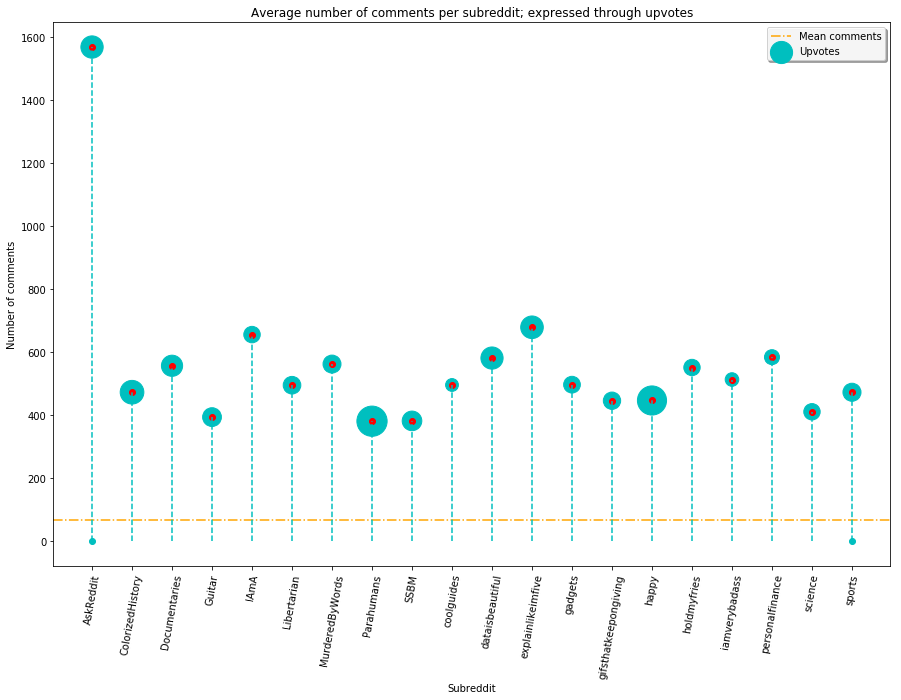

In [20]:
'''

AVERAGE NUMBER OF COMMENTS PER SUBREDDIT

Cool thing - this graph shows that there are reddits that have the number of comments higher than average.
If you zoom in and out, you'll see that the number of such reddits is pretty high.

This is the evidence that there are some subreddits that are simply more popular than the rest.

'''

# sliced and sorted by reddit and num_comms
plot_this = df.groupby('subreddit').mean().sort_values('num_comments', ascending = False)[:20] 

plt.figure(figsize = (15, 10))

upvotes = plt.scatter(plot_this.sort_values('num_comments', ascending = True).index, 
            plot_this.sort_values('num_comments', ascending = True).num_comments, 
            c = 'c', s = df['upvotes'] ** 0.6)

plt.xlabel('Subreddit')
plt.ylabel('Number of comments')
plt.xticks(rotation = 80)

'''

Draw a line at median and mean comments.

'''

mean_comments = plt.axhline(y=df.num_comments.mean(), color='orange', linestyle='-.')

plt.stem(plot_this.sort_values('num_comments', ascending = False).index, 
         plot_this.sort_values('num_comments', ascending = False).num_comments, 
         linefmt='c--', markerfmt='ro', basefmt='co')

plt.legend([mean_comments, upvotes], 
           ['Mean comments', 'Upvotes'],
          framealpha=0.9, shadow=True, fancybox=True)

plt.title('Average number of comments per subreddit; expressed through upvotes')
plt.savefig('subreddit_comments.png');

In [21]:
'''

We have dates posted. Is the day/date of posting predictive of comments? Let's strip the time and plot.

'''

from datetime import datetime

df['year_created'] = df.created_at.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year)
df['month_created'] = df.created_at.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").month)
df['day_created'] = df.created_at.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").day)
df['hour_created'] = df.created_at.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").hour)
df['minute_created'] = df.created_at.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").minute)
df['second_created'] = df.created_at.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").second)


df.created_at = df.created_at.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
df['day_of_week_created'] = df.created_at.apply(lambda x: x.isocalendar()[2])

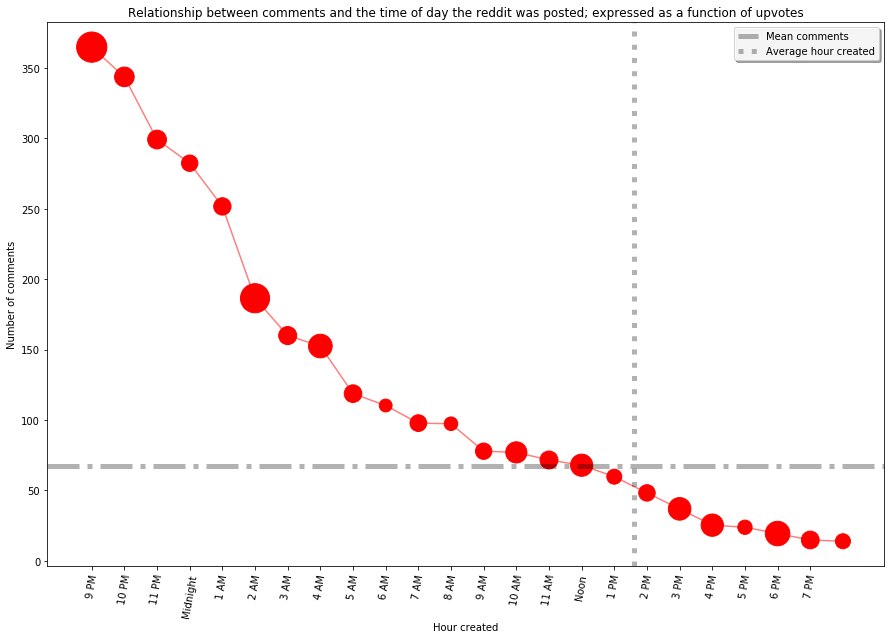

In [22]:
'''

Is there a relationship between the average number of comments and the time of day that they are posted?

'''

import numpy as np

plot_this = df.groupby('hour_created').mean().sort_values('num_comments', ascending = False)
plot_this.index = [-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

plt.figure(figsize = (15, 10))

plt.axvspan(-3, 7, ymin = 100, facecolor='#2ca02c', alpha=0.1)


plt.scatter(plot_this.index, plot_this['num_comments'], c = 'r', s = df['upvotes'] ** 0.6)
line_upvotes = plt.plot(plot_this['num_comments'], c = 'r', alpha = 0.5)
plt.xlabel('Hour created')
plt.ylabel('Number of comments')

x_ticks_labels = ['9 PM', '10 PM', '11 PM', 'Midnight', '1 AM',
                  '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', 
                  '8 AM', '9 AM', '10 AM', '11 AM', 'Noon', 
                  '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM']
plt.xticks(np.arange(-3, 20, 1.0), x_ticks_labels, rotation=80)


'''

Draw a line at median and mean comments.

'''

mean_comments = plt.axhline(y=df.num_comments.mean(), color='black', lw = 5, linestyle='-.', alpha = 0.3)
mean_hours = plt.axvline(x=df.hour_created.mean(), color='black', linestyle=':', lw = 5, alpha = 0.3)

plt.legend([mean_comments,  mean_hours,], 
           ['Mean comments', 'Average hour created'], 
           fancybox=True, framealpha=0.9, shadow=True)

plt.title('Relationship between comments and the time of day the reddit was posted; expressed as a function of upvotes')

plt.savefig('comments_vs_time_of_day_posted_mean.png');

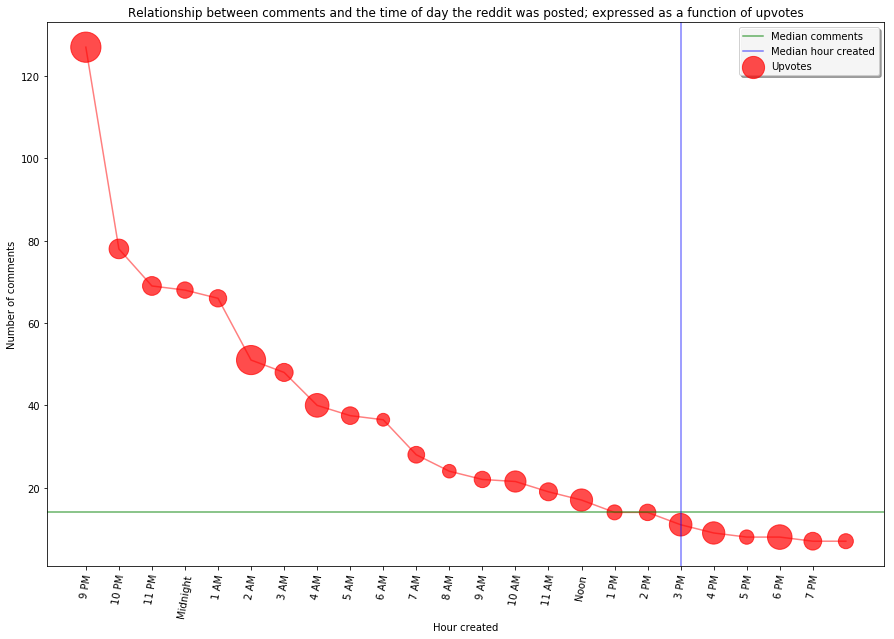

In [23]:
'''

What if you're looking at the median?

'''

plot_this = df.groupby('hour_created').median().sort_values('num_comments', ascending = False)
plot_this.index = [-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

plt.figure(figsize = (15, 10))

upvotes = plt.scatter(plot_this.index, plot_this['num_comments'], c = 'r', s = df['upvotes'] ** 0.6, alpha = 0.7)
line_upvotes = plt.plot(plot_this['num_comments'], c = 'r', alpha = 0.5)



plt.xlabel('Hour created')
plt.ylabel('Number of comments')

x_ticks_labels = ['9 PM', '10 PM', '11 PM', 'Midnight', '1 AM',
                  '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', 
                  '8 AM', '9 AM', '10 AM', '11 AM', 'Noon', 
                  '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM']
plt.xticks(np.arange(-3, 20, 1.0), x_ticks_labels, rotation=80)



'''

Draw a line at median and mean comments.

'''

mean_comments = plt.axhline(y=df.num_comments.median(), color='g', linestyle='-', alpha = 0.6)
mean_hours = plt.axvline(x=df.hour_created.median(), color='b', linestyle='-', alpha = 0.5)

plt.legend([mean_comments,  mean_hours, upvotes], 
           ['Median comments', 'Median hour created', 'Upvotes'], 
           fancybox=True, framealpha=0.9, shadow=True)

plt.title('Relationship between comments and the time of day the reddit was posted; expressed as a function of upvotes')

plt.savefig('comments_vs_time_of_day_posted_median.png');

In [24]:
'''

Get sentiment analysis over time of day:

1. Run a sentiment analysis model on titles.
2. Make sure the lengths of the lists are correct.
3. Append to the dataframe.

'''

# 1

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

negative = []
neutral = []
positive = []
comp = []


analyzer = SentimentIntensityAnalyzer()

for title in df.title:
    vs = analyzer.polarity_scores(title)
    negative.append(vs['neg'])
    neutral.append(vs['neu'])
    positive.append(vs['pos'])
    comp.append(vs['compound'])

# 2 

print 'Neg: {}, neu: {}, pos: {}, comp: {}'.format(len(negative), len(neutral), len(positive), len(comp))

# 3

df['negative'] = negative
df['neutral'] = neutral
df['positive'] = positive
df['composite'] = comp

Neg: 11120, neu: 11120, pos: 11120, comp: 11120


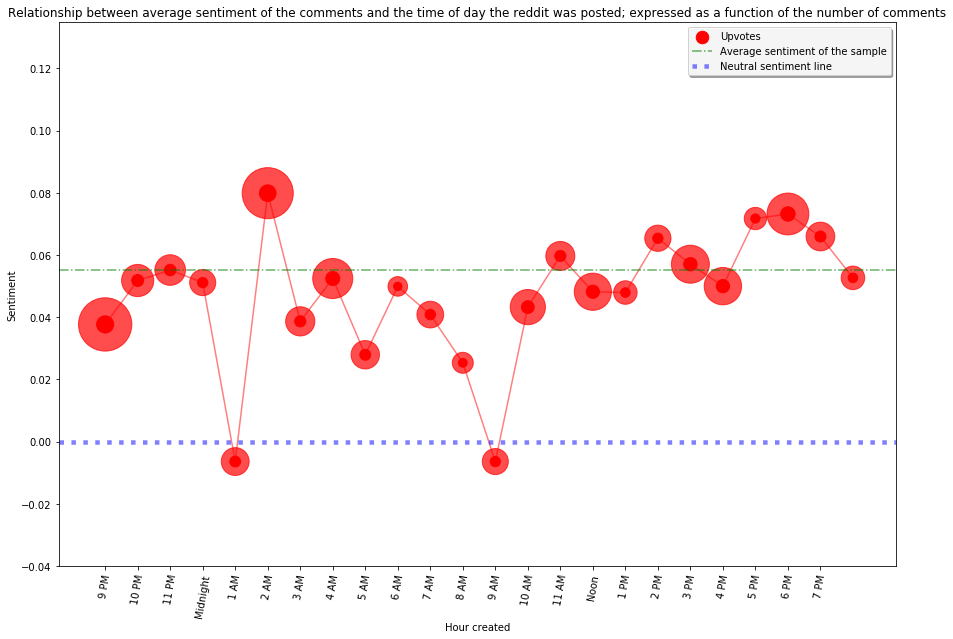

In [30]:
'''

On the following graph, the blue line is the absolutely neutral sentiment and the green line denotes the average 
sentiment across the entire dataset. 

You can see that the sentiment of Reddit overall is lukewarm with a few exceptions.

'''

plot_this = df.groupby('hour_created').mean().sort_values('num_comments', ascending = False)
plot_this.index = [-3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

plt.figure(figsize = (15, 10))

upvotes = plt.scatter(plot_this.index, plot_this['composite'], c = 'r', s = df['upvotes'] ** 0.7, alpha = 0.7)
upvotes = plt.scatter(plot_this.index, plot_this['composite'], c = 'r', s = df['upvotes'] ** 0.5, alpha = 1)
line_upvotes = plt.plot(plot_this['composite'], c = 'r', alpha = 0.5)


plt.xlabel('Hour created')
plt.ylabel('Sentiment')

x_ticks_labels = ['9 PM', '10 PM', '11 PM', 'Midnight', '1 AM',
                  '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', 
                  '8 AM', '9 AM', '10 AM', '11 AM', 'Noon', 
                  '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM']
plt.xticks(np.arange(-3, 20, 1.0), x_ticks_labels, rotation=80)



'''

Draw a line at median and mean comments.

'''

mean_sentiment = plt.axhline(y=df.composite.mean(), color='g', linestyle='-.', alpha = 0.6)
zero = plt.axhline(y=0, color='b', linestyle=':', alpha = 0.5, lw = 4.5)

plt.legend([upvotes, mean_sentiment, zero], 
           ['Upvotes', 'Average sentiment of the sample', 'Neutral sentiment line'], 
           fancybox=True, framealpha=0.9, shadow=True)

plt.title('Relationship between average sentiment of the comments and the time of day the reddit was posted; expressed as a function of the number of comments')

plt.savefig('mood_vs_time_of_day_posted_mean.png');

In [31]:
'''

Combine and transform the sentiment to be weighed by the number of comments.

'''


from sklearn.preprocessing import MinMaxScaler

mmax = MinMaxScaler(feature_range = (-1, 1))

df['weighted_sentiment'] = df['num_comments'] * df['composite']

df['weighted_sentiment'] = mmax.fit_transform(pd.DataFrame(df.weighted_sentiment))

df.weighted_sentiment.describe()

count    11120.000000
mean         0.684789
std          0.018269
min         -1.000000
25%          0.684728
50%          0.684728
75%          0.684810
max          1.000000
Name: weighted_sentiment, dtype: float64

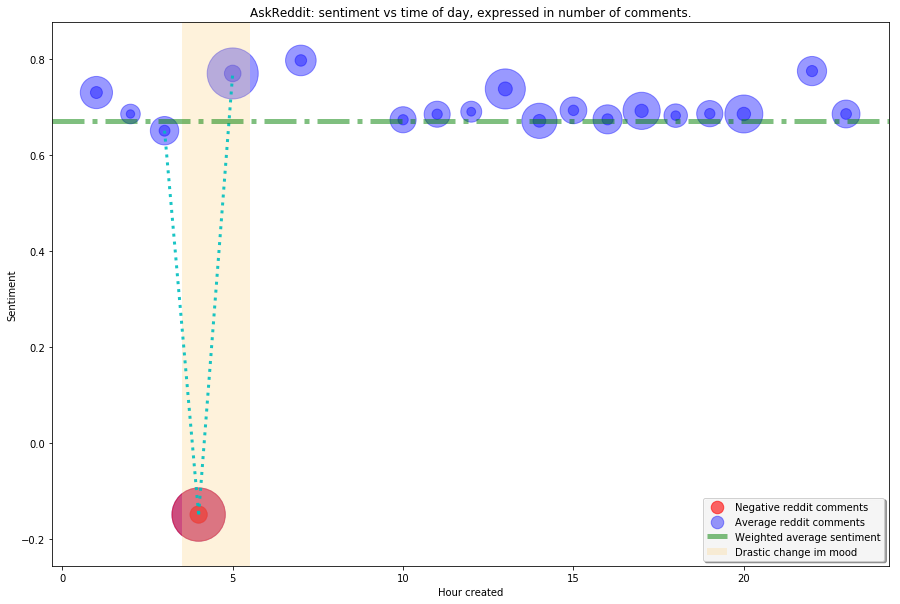

In [32]:
'''

Green line is the weighted average sentiment across AskReddit.
Here, you can see a significant mood drop around 4 AM.

'''

plot_this = df[df['subreddit'] == 'AskReddit'].groupby('hour_created').mean().sort_values('num_comments', ascending = False)

plt.figure(figsize = (15, 10))

change = plt.axvspan(3.5, 5.5, facecolor='#fed789', alpha=0.3)

upvotes = plt.scatter(plot_this.index, plot_this['weighted_sentiment'], c = 'b', s = df['upvotes'] ** 0.7, alpha = 0.4)
upvotes_s = plt.scatter(plot_this.index, plot_this['weighted_sentiment'], c = 'b', s = df['upvotes'] ** 0.5, alpha = 0.4)
upvotes_o = plt.scatter(4, plot_this.loc[4]['weighted_sentiment'], c = 'r', s = df['upvotes'] ** 0.7, alpha = 0.5)
upvotes_o = plt.scatter(4, plot_this.loc[4]['weighted_sentiment'], c = 'r', s = df['upvotes'] ** 0.5, alpha = 0.6)

plt.plot([3, 4], [plot_this.loc[3]['weighted_sentiment'], plot_this.loc[4]['weighted_sentiment']], 'c:', lw=3, alpha = 0.9)
plt.plot([4, 5], [plot_this.loc[4]['weighted_sentiment'], plot_this.loc[5]['weighted_sentiment']], 'c:', lw=3, alpha = 0.9)

plt.xlabel('Hour created')
plt.ylabel('Sentiment')


'''

Draw a line at true mean of the comments.

'''

mean_sentiment = plt.axhline(y=df[df['subreddit'] == 'AskReddit'].weighted_sentiment.mean(), lw = 5, color='g', linestyle='-.', alpha = 0.5)



plt.legend([upvotes_o, upvotes_s, mean_sentiment, change], 
           ['Negative reddit comments','Average reddit comments', 'Weighted average sentiment', 'Drastic change im mood'], 
           fancybox=True, framealpha=0.9, shadow=True, loc = 'lower right')

plt.title('AskReddit: sentiment vs time of day, expressed in number of comments.')

plt.savefig('AskReddit_mood_vs_time_of_day_posted_mean.png');

# Modeling

In [33]:
'''

Make subreddits into labels and dummies.

'''

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

df['subreddit_labels'] = le.fit_transform(df['subreddit'])

In [34]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

cv = StratifiedKFold(n_splits=10, random_state=21, shuffle=True)

X = df.drop(['created_at', 'high', 'subreddit', 'time_delta', 'time_now', 'title', 'num_comments'], axis = 1)
y = df['high']

dt = DecisionTreeClassifier(class_weight='balanced')
bdt = BaggingClassifier(DecisionTreeClassifier())
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1, n_estimators=100)
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)
ab = AdaBoostClassifier()
gb = GradientBoostingClassifier()
lr = LogisticRegression(penalty = 'l2')
nb = BernoulliNB()
knn = KNeighborsClassifier()

def score(model, name):
    s = cross_val_score(model, X, y, cv=cv)
    print("{} score:\t{:0.3} ± {:0.3}".format(name, s.mean().round(3), s.std().round(3)))

score(ab, "AdaBoost")
score(gb, "Gradient Boosting Classifier")
score(dt, "Decision Tree")
score(bdt, "Bagging DT")
score(rf, "Random Forest")
score(et, "Extra Trees")
score(knn, "KNN")

'''

MaxEnt doesn't do well on labels. Let's get dummies.

'''

X = df.drop(['created_at', 'high', 'subreddit', 'time_delta', 'time_now', 'title', 'num_comments', 'subreddit_labels'], axis = 1)

score(lr, "Logistic Regression")
score(nb, "Naive Bayes")

AdaBoost score:	0.83 ± 0.01
Gradient Boosting Classifier score:	0.833 ± 0.01
Decision Tree score:	0.775 ± 0.009
Bagging DT score:	0.816 ± 0.008
Random Forest score:	0.808 ± 0.011
Extra Trees score:	0.713 ± 0.014
KNN score:	0.63 ± 0.014
Logistic Regression score:	0.671 ± 0.013
Naive Bayes score:	0.541 ± 0.009
